# week 10 information theory.

In [3]:
print("Hello,world")


Hello,world


In [4]:
import zlib #also izma

text = "here is some text some text text text with repition"
print(f"orginal text {len(text)} bytes:", text)

text_bytes = text.encode('ascii')
comp = zlib.compress(text_bytes)
print(f"compressed text {len(comp)} bytes:", comp)

decomp = zlib.decompress(comp)
print("decompressed text:", decomp.decode('ascii'))

ratio = len(comp) / len(text_bytes)
print(f"compression ration: {ratio:.2f}")


orginal text 51 bytes: here is some text some text text text with repition
compressed text 41 bytes: b'x\x9c\xcbH-JU\xc8,V(\xce\xcfMU(I\xad(Ab!\x88\xf2\xcc\x92\x0c\x85\xa2\xd4\x82\xcc\x92\xcc\xfc<\x00\xebX\x13C'
decompressed text: here is some text some text text text with repition
compression ration: 0.80


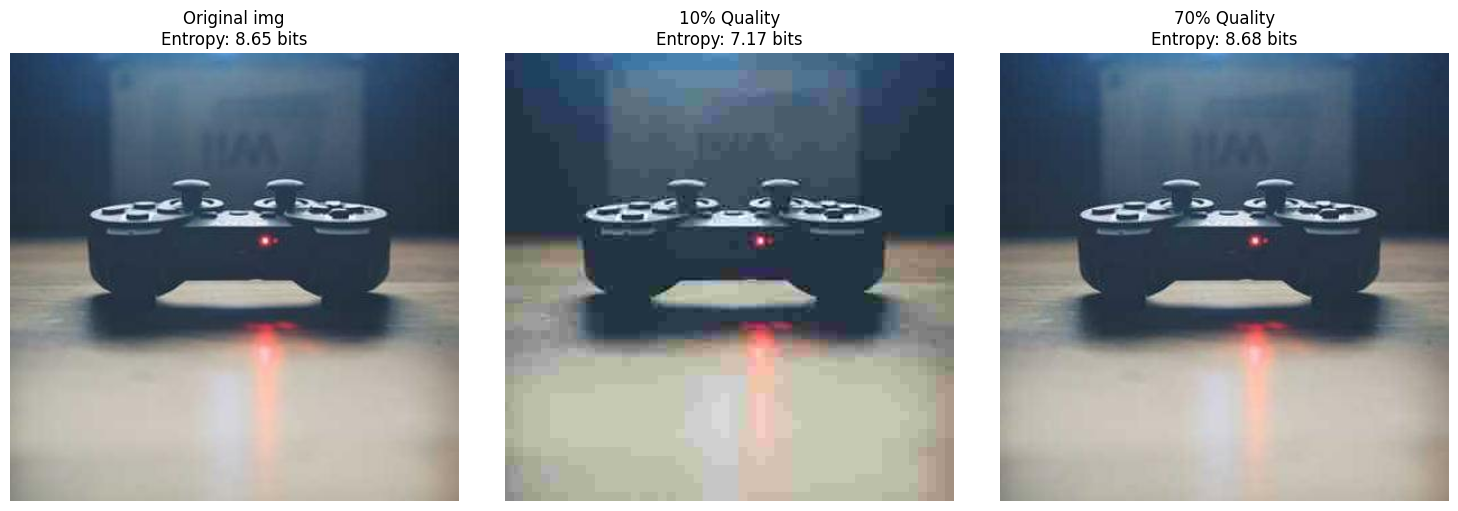

In [5]:
import requests 
import numpy as np 
import matplotlib.pyplot as plt 
from PIL import Image
from io import BytesIO

def entropy(img):
    histogram = img.histogram()
    probs = [float(h)/ sum(histogram) for h in histogram]
    return -sum(p * np.log2(p) for p in probs if p != 0) 

def compress(img, quality=75):
    fname = f'../images/q_{quality}.jpg'
    img.save(fname, 'JPEG', quality=quality)
    compressed = Image.open(fname)
    return compressed, entropy(compressed)

url = 'https://picsum.photos/400/400'
response = requests.get(url)
original = Image.open(BytesIO(response.content))

qualities = [10, 70]
images = [original]
entropies = [entropy(original)]
titles = ['Original img']
for q in qualities:
    img_c, img_h = compress(original, q)
    images.append(img_c)
    entropies.append(img_h)
    titles.append(f'{q}% Quality')

plt.figure(figsize=(15,5))
for lcv, (img, ent, title) in enumerate(zip(images,entropies,titles),start=1):
    plt.subplot(1, len(images), lcv)
    plt.imshow(img)
    plt.title(f"{title}\nEntropy: {ent:.2f} bits")
    plt.axis('off')

plt.tight_layout()
plt.show()


Week 11

In [6]:
%pip install faker tqdm -q
from tqdm import tqdm
from queue import Queue
from faker import Faker
from time import time, sleep



[notice] A new release of pip is available: 24.2 -> 24.3.1
[notice] To update, run: python -m pip install --upgrade pip
Note: you may need to restart the kernel to use updated packages.


In [7]:
#11/12/2024
class Device:
    def __init__(self,name):
        self.ip = ""
        self.name = name
        self.inbox = Queue()
    
    def send(self, recip, msg):
        print(f"{self.name} is sending {len(msg)} bytes to {recip.ip}")
        for _ in tqdm(range(len(msg)), desc = "Sending", ncols=100):
            sleep(0.25) # ~32 bits/s
        recip.inbox.put(msg.encode('ascii'))

    def receive(self):
        if not self.inbox.empty():
            msg = self.inbox.get().decode('ascii')
            print(f"{self.name} received a message: {msg}")
            return len(msg)
        return 0


In [8]:
class Network:
    def __init__(self):
        self.devices = []
        self.dhcp = Faker()
        self.start_time = time()
        self.usage = 0

    def add_device(self, device:  Device):
        device.ip = self.dhcp.ipv4()
        self.devices.append(device)

    def sim_traffic(self):
        for device in self.devices:
            self.usage += device.receive()

    def display(self):
        print(f"Uptime: {time()- self.start_time:.4} seconds")
        print(f"data Usage: {self.usage} bytes")
        print("Connected devices:")
        for d in self.devices:
            print(f"{d.name}\t\t{d.ip}")

In [ ]:
alice = Device("Alice")
bob = Device("Bob")

network = Network()
network.add_device(alice)
network.add_device(bob)

while True:
    sender_name = input("Who are you (Alice/Bob)")
    if sender_name == "Alice":
        sender, recip = alice, bob
    elif sender_name == "Bob":
        sender, recip = bob, alice
    else:
        print("Invalid name")
        continue

    msg = input("Enter your message: ")
    sender.send(recip,msg)
    network.sim_traffic()

    loop = input("Do you want to send another messgae (y/n)")
    if loop not in "yes":
        break
    


network.display()

# Week 12 - TCP-IP Model

In [ ]:
%pip install faker tqdm termcolor -q
import random
from tqdm import tqdm
from time import sleep
from faker import Faker
from termcolor import colored



[notice] A new release of pip is available: 24.2 -> 24.3.1
[notice] To update, run: python -m pip install --upgrade pip
Note: you may need to restart the kernel to use updated packages.


In [ ]:
def print_sleep(msg, seconds=1):
    print(msg)
    sleep(seconds)

def do_progress(length, desc, seconds=0.05):
    for _ in tqdm(range(length), desc=desc, ncols=100):
        sleep(seconds)

In [ ]:
class ApplicationLayer:
    def __init__(self, data):
        self.data = data

    def prepare_data(self):
        print_sleep(colored("Application Layer: ", "cyan") + f"preparing data '{self.data}'")
        return self.data.encode()
    
class TransportLayer:
    def __init__(self, protocol="TCP", port=80):
        self.protocol = protocol
        self.port = port
        self.sequence_num = random.randint(1, 1000)

    def prepare_segment(self, data):
        header = colored("Transport Layer: ", "magenta")
        if self.protocol == "TCP":
            print_sleep(header + f"Using TCP on port {self.port} - establish connection ...")
            #TCP HANDSHAKE
            print_sleep(header + f"SYN packet (Seq={self.sequence_num})",0.5)
            print_sleep(header + f"SYN-ACK packet (Seq={self.sequence_num+1})", 0.5)
            print_sleeP(header + f"ACK packet - Connection established",0.5)
        else:
            print(header+ f"Using UDP on Port {self.port} - No connection setup required.")

        segment = f"{self.protocol}-Port-{self.port}-Segment-{self.sequence_num}|{data.decode()}"
        do_progress(len(segment), "Transport Layer Processing")
        return segment.encode()

class InternetLayer:
    def __init__(self, src_ip, dest_ip ):
        self.src_ip = src_ip
        self.dest_ip = dest_ip

    def prepare_packet(self, segment):
        print_sleep(colored("Interent layer: ", "yellow")+f"adding IP header(Source; {self.src_ip}, destination: {self.dest_ip}")
        packet = f"IP: {self.src_ip}>{self.dest_ip}|{segment.decode()}"
        do_progress(len(packet), "Internet Layer Processing")
        return packet.encode
    
class NetworkAccessLayer:
    def __init__(self, src_mac, dest_mac):
        self.src_mac = src_mac
        self.dest_mac = dest_mac

    def prepare_frame(self, packet):
        print_sleep(colored("Network Access Layer: ", "green")+f"adding MAC header (source: {self.src_mac}, Destination: {self.dest_mac})")
        frame = f"MAC:{self.src_mac}>{self.dest_mac}|{packet.decode()}"
        do_progress(len(frame), "network access layer processing")
        return frame.encode()


In [ ]:
class InternetDevice:
    def __init__(self,name,ip,mac):
        self.name = name
        self.ip = ip
        self.mac = mac

    def send(self, dest_device, data, port-80):
        app_data = ApplicationLayer(data).prepare_data()
        segment = TransportLayer("TCP").prepare_segment(app_data)
        packet = InternetLayer(self.ip, dest_device.ip).prepare_packet(segment)
        frame = NetworkAccessLayer(self, dest_device.mac).prepare_frame(packet)
        print_sleep(f"\n{self.name} is sending data to {dest_device.name} on port {port}")
        dest_device.receive(frame)

    def receive(self,frame):
        print(f"{self.name} received data:\n{frame.decode()}\n")
        print("Processing data through layers...", 0.1)
        do_progress(5, "network Access layer Decapsulation", 0.1)
        split_frame = frame.decode().split("|")
        del split_frame[0] #Remove MAC header
        do_progress(5, "Network Access Layer Decapsulation", 0.1)
        del split_frame[0] #Remove IP header
        do_progress(5, "network Access Layer Decapsulation", 0.1)
        del split_frame[0] #Remove TCP/UDP header
        do_progress(5, "Network Access Layer Decapsulation", 0.1)
        print(f"\nData received:\n{split_frame[0]}")

In [ ]:
router = Faker()
device1 = InternetDevice("computerA", router.ipv4(), router.mac_address())
device2 = InternetDevice("computerB", router.ipv4(), router.mac_address())
device1.send(device2, "hello from ComputerA!", port=80) 